In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from scipy.optimize import curve_fit
from math import floor, log10


In [20]:
"""
Cleaned CSV has columns:

            'baseline': mean_b_array,
            'sd_baseline': sigma_b_array,
            'amplitude': all_amplitudes,
            'peak_time': all_peak_times,
            'FWHM': all_FWHM,
            't1_of_FWHM': all_t1,
            't2_of_FWHM': all_t2,
            'time_above_15sigma': all_time_above_15thresh,
            'first_15sigma_crossing': all_first_15crossing,
            'second_15sigma_crossing': all_second_15crossing,
            'time_above_10sigma': all_time_above_10thresh,
            'first_10sigma_crossing': all_first_10crossing,
            'second_10sigma_crossing': all_second_10crossing,
            'time_above_5sigma': all_time_above_5thresh,
            'first_5sigma_crossing': all_first_5crossing,
            'second_5sigma_crossing': all_second_5crossing,
            'integral_pC': all_integrals_picocharge,
            'peaks_over_15sigma_threshold': number_of_maxima_all,
            'event_timestamps' : event_timestamps[:-1]
"""

"\nCleaned CSV has columns:\n\n            'baseline': mean_b_array,\n            'sd_baseline': sigma_b_array,\n            'amplitude': all_amplitudes,\n            'peak_time': all_peak_times,\n            'FWHM': all_FWHM,\n            't1_of_FWHM': all_t1,\n            't2_of_FWHM': all_t2,\n            'time_above_15sigma': all_time_above_15thresh,\n            'first_15sigma_crossing': all_first_15crossing,\n            'second_15sigma_crossing': all_second_15crossing,\n            'time_above_10sigma': all_time_above_10thresh,\n            'first_10sigma_crossing': all_first_10crossing,\n            'second_10sigma_crossing': all_second_10crossing,\n            'time_above_5sigma': all_time_above_5thresh,\n            'first_5sigma_crossing': all_first_5crossing,\n            'second_5sigma_crossing': all_second_5crossing,\n            'integral_pC': all_integrals_picocharge,\n            'peaks_over_15sigma_threshold': number_of_maxima_all,\n            'event_timestamps' : ev

In [21]:
"""
Need to find an average over three trials.
Some trials end up having very low numbers of events (super noisy data collection), these shouldn't be considered.
Need to plot dark rate against voltage. 
Try using the naming convention to loop over events and plot them? 

Name: date+note+voltage+10000+trialnumber+lights+clean.csv

"""

"\nNeed to find an average over three trials.\nSome trials end up having very low numbers of events (super noisy data collection), these shouldn't be considered.\nNeed to plot dark rate against voltage. \nTry using the naming convention to loop over events and plot them? \n\nName: date+note+voltage+10000+trialnumber+lights+clean.csv\n\n"

In [22]:
#15sigma threshold

#eliminate files with less than 1000 events in after cleaning.

allfiles = glob.glob('PMT5_Cleaned/*cleaned.csv')

enough_events = []

for f in allfiles:
    df = pd.read_csv(f)
    if len(df)<500:
        print(f"Discarding {f}, only {len(df)} events after cleaning")
        continue
    enough_events.append(f)



Discarding PMT5_Cleaned\270126_darkrate_1850_10000_1_on_processed_threshold24_cleaned.csv, only 319 events after cleaning
Discarding PMT5_Cleaned\270126_darkrate_1850_10000_1_on_processed_threshold25_cleaned.csv, only 319 events after cleaning
Discarding PMT5_Cleaned\270126_darkrate_1850_10000_1_on_processed_threshold26_cleaned.csv, only 319 events after cleaning


In [23]:
#15sigma threshold

# first find the place value of the smallest digit in the timesteps:
def last_digit_place_value(x):
    """
    Returns the place value of the last digit in x.
    Example: 0.1234 -> 0.0001, 15.20 -> 0.01, 5000 -> 1000
    """
    s = str(x)

    # Handle scientific notation
    if 'e' in s.lower():
        s = format(float(x), '.15f').rstrip('0').rstrip('.')

    if '.' in s:
        frac_part = s.split('.')[1]
        return 10 ** (-len(frac_part))
    else:
        trailing_zeros = len(s) - len(s.rstrip('0'))
        return 10 ** trailing_zeros
    
#calculate dark rate for each csv in enough_events and their errors
raw_storage = {}
for file in enough_events:
    df = pd.read_csv(file)
    timestamp_column = df['event_timestamps']
    timetaken = timestamp_column.iloc[-1] - timestamp_column.iloc[0]
    amplitude_column = df['amplitude']
    dark_rate = len(amplitude_column) / timetaken

    if dark_rate > 3000: 
        print(f"Discarding {file} due to unusual dark rate = {dark_rate:.3f}Hz")
        continue
# calculate errors
    N = len(amplitude_column)
    t_last_err = 0.5 * last_digit_place_value(timestamp_column.iloc[-1])
    t_first_err = 0.5 * last_digit_place_value(timestamp_column.iloc[0])
    t_err = np.sqrt(t_last_err**2 + t_first_err**2)
    DR_err = np.sqrt((np.sqrt(N)/timetaken)**2 + ((N*t_err)/timetaken**2)**2)
    #DR_err = np.sqrt((np.sqrt(N)/timetaken)**2 + ((N*t_err)/timetaken**2)**2 +(0.05*dark_rate)**2)
    print(DR_err)

    match = re.search(r"darkrate_(\d+)_10000_(\d+)_(on|off)_processed_threshold(\d+).*", file)
    if not match:
        continue
    
    voltage = int(match.group(1))
    light_state = match.group(3)
    thresh = int(match.group(4)) # e.g., 11

    raw_storage.setdefault(thresh, {}).setdefault(voltage, {}).setdefault(light_state, []).append((dark_rate, DR_err))


    #dark_rates[file] = (dark_rate, DR_err)
    #print(f"{file} has dark rate = {dark_rate:.3f} Hz")
    #print(f"{file} ",'amount of events in clean files', len(amplitude_column))

#PUT ERROR PROPAGATION HERE FOR EACH RATE

0.1727156857171263
0.17252840027488314
0.17237401241373862
0.18745961812803355
0.1872437750879704
0.18696761303270987
0.20484292010827135
0.20426759831459482
0.2036617612957281
0.46177531240900666
0.46133698738150325
0.46078117710643857
1.0405743473150642
1.0396180833538646
1.0389800850836797
0.4609701823270821
0.4601635847146961
0.45899599688570497
0.8993740409198723
0.8992877130574001
0.8986660855316957
0.9284375828581017
0.9282826237344558
0.9281793032796047
1.144068947370741
1.1437012174804777
1.1426586734584965
1.1174944664356645
1.1168391666948616
1.1160045923411217
1.1028989902273791
1.1026541464036874
1.1017354974510747
1.5131967906984047
1.51294014992023
1.512341152071496
1.3858439945884216
1.3859927461580646
1.3855464435394549
3.6183486503663844
3.6148844574703323
3.6114169416051807
1.7623718610333454
1.7620869718657055
1.7618020366305536
1.837683100596867
1.8375834620737046
1.8374838181475908
1.6193366510970635
1.6194228479220305
1.6193366510970635


0.05278861708868021
0.12001334439611239
0.1253756485595403
0.3352190008733813
0.05056890152163618
0.6478763170956234
0.1297867207663046
0.65991346074448
0.06653141796981288
0.9856840348540983
0.022744659959698765
1.0004969308652318
[1750 1800 1850 1900 1950 2000]


<>:165: SyntaxWarning: invalid escape sequence '\p'
<>:177: SyntaxWarning: invalid escape sequence '\p'
<>:191: SyntaxWarning: invalid escape sequence '\c'
<>:165: SyntaxWarning: invalid escape sequence '\p'
<>:177: SyntaxWarning: invalid escape sequence '\p'
<>:191: SyntaxWarning: invalid escape sequence '\c'
C:\Users\holly\AppData\Local\Temp\ipykernel_45548\610287874.py:165: SyntaxWarning: invalid escape sequence '\p'
  return f"{val:.1e} \pm {err:.1e}"
C:\Users\holly\AppData\Local\Temp\ipykernel_45548\610287874.py:177: SyntaxWarning: invalid escape sequence '\p'
  return (f"({scaled_val:.{n}f} \pm {scaled_err:.{n}f}) "
C:\Users\holly\AppData\Local\Temp\ipykernel_45548\610287874.py:191: SyntaxWarning: invalid escape sequence '\c'
  label_on += f'\n$\chi^2_\\nu$ = {fmt_sig_figs(chi2nu_on, n=2)}'
C:\Users\holly\AppData\Local\Temp\ipykernel_45548\610287874.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are igno

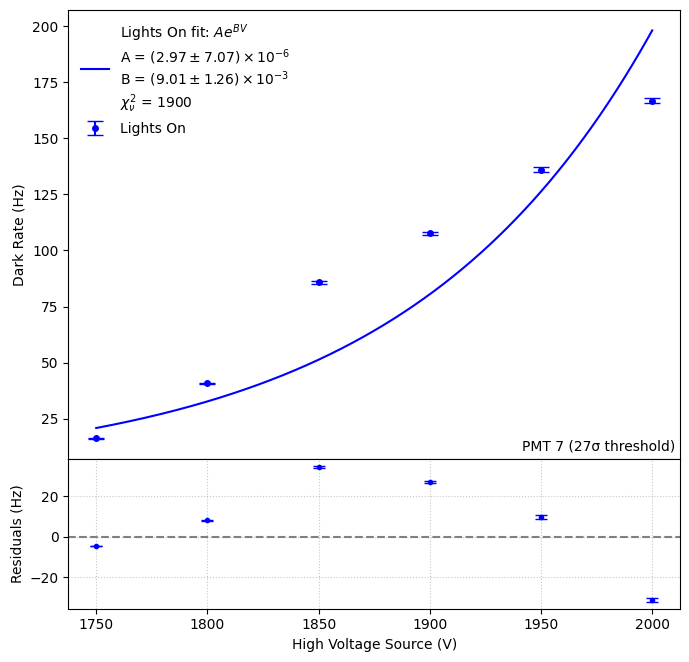

In [ ]:
#15sigma threshold
#plot dark rate against voltage for lights on and lights off on the same plot.

#these will be lists of voltages with their corresponding dark rates. eg. {1750: [213,453,241], 2000: [542,622,315]}
lights_on = {} 
lights_off = {}

central_t = 25
low_t = 24
high_t = 26

def get_weighted_stats(thresh, volt, state):
    data = raw_storage.get(thresh, {}).get(volt, {}).get(state, [])
    if not data: return None, None
    
    rates, errs = zip(*data)
    rates, errs = np.array(rates), np.array(errs)
    weights = 1 / (errs**2)
    
    w_mean = np.sum(weights * rates) / np.sum(weights) # weighted mean
    w_err = np.sqrt(1 / np.sum(weights)) # weighted error
    return w_mean, w_err

# Process all voltages found in the central threshold
all_voltages = []
all_voltages = sorted(raw_storage.get(central_t, {}).keys())

for voltage in all_voltages:
    for state in ['on']:
        # Get Weighted Mean and Stat Error for Threshold 11 (central voltage)
        mean_cen, err_cen = get_weighted_stats(central_t, voltage, state)
        if mean_cen is None: continue
        
        # Get Weighted Means for Threshold 10 and 12
        mean_low, _ = get_weighted_stats(low_t, voltage, state)
        mean_high, _ = get_weighted_stats(high_t, voltage, state)
        
        # 3. Calculate Systematic Error: |Rate_high - Rate_low| / 2
        if mean_low is not None and mean_high is not None:
            sys_err = abs(mean_high - mean_low) / 2
            print(sys_err)
        else:
            sys_err = 0.0 # Default if bounds are missing

        # 4. Combine Stat and Sys Error in Quadrature
        total_err = np.sqrt(err_cen**2 + sys_err**2)
        print(total_err)
        
        # Store in your original lights_on / lights_off dictionaries
        if state == 'on':
            lights_on[voltage] = (mean_cen, total_err)
        else:
            lights_off[voltage] = (mean_cen, total_err)

def get_plot_arrays_on(lights_on):
    voltage = sorted(lights_on.keys())
    rate = np.array([lights_on[i][0] for i in voltage])
    err = np.array([lights_on[i][1] for i in voltage])
    mask = np.isfinite(rate) & (err > 0)
    return np.array(voltage)[mask], rate[mask], err[mask]
'''
def get_plot_arrays_off(lights_off):
    voltage = sorted(lights_off.keys())
    rate = np.array([lights_off[i][0] for i in voltage])
    err = np.array([lights_off[i][1] for i in voltage])
    mask = np.isfinite(rate) & (err > 0)
    return np.array(voltage)[mask], rate[mask], err[mask]
'''

def exponential_C(V, A, B, C):
    return A * np.exp(B * V) + C

def exponential(V, A, B):
    return A * np.exp(B * V)

def linear(V, m, c):
    return m*V + c

V_fit_on, Rate_fit_on, Err_fit_on = get_plot_arrays_on(lights_on)

print(V_fit_on)

try:
    popt_on, pcov_on = curve_fit(
        f=exponential,
        xdata=V_fit_on,
        ydata=Rate_fit_on,
        sigma=Err_fit_on,
        absolute_sigma=False,
        p0=[1e-6, 0.01]  # Initial guess for A, B
    )
    rate_fit_on_points = exponential(V_fit_on, *popt_on)
    perr_on = np.sqrt(np.diag(pcov_on))
except RuntimeError:
    print("Lights On curve fit failed.")
    popt_on = None

V_dense_on = np.linspace(np.min(V_fit_on), np.max(V_fit_on), 1000)
Rate_dense_on = exponential(V_dense_on, *popt_on)



fig, (ax_main, ax_res) = plt.subplots(
    nrows=2, 
    ncols=1, 
    sharex=True, 
    figsize=(7, 7), 
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0} # 3:1 ratio and no vertical space
)



# --- Residuals Calculation and Plotting ---



# 1. Calculate and Plot Lights On Residuals
if popt_on is not None:
    # Residuals = (Measured Rate) - (Fitted Rate at that Voltage)
    residuals_on = Rate_fit_on - rate_fit_on_points
    
    # Optional: Plot standardized residuals (Residuals / Error) if you want to normalize by uncertainty
    # standardized_residuals_on = residuals_on / average_err_on_np
    ax_res.errorbar(
        V_fit_on, 
        residuals_on, 
        yerr=Err_fit_on, 
        ms=3, 
        capsize=4, 
        fmt='o', 
        color='blue')#, 
        #label='Lights On Residuals'
    #)


# ---- Chi-squared: Lights ON ----
chi2_on = None
chi2nu_on = None

if popt_on is not None:
    non_zero = Err_fit_on > 0
    chi2_on = np.sum((residuals_on[non_zero] / Err_fit_on[non_zero])**2)
    nu_on = len(Rate_fit_on[non_zero]) - len(popt_on)
    chi2nu_on = chi2_on / nu_on


# corect decimal places
def fmt_sig_figs(val, n=2):
    """Rounds a number to n significant figures and returns as a string."""
    if val == 0:
        return "0"
    # Calculate the order of magnitude
    mag = floor(log10(abs(val)))
    # Round to the appropriate decimal place
    rounded_val = round(val, -int(mag - (n - 1)))
    # Format as a float to avoid scientific notation in the string
    return f"{rounded_val:g}"

def format_scientific_latex(val, err, n=2):
    """
    Formats a value and error into LaTeX scientific notation 
    sharing the same power of 10.
    """
    if err <= 0:
        return f"{val:.1e} \pm {err:.1e}"

    # 1. Find the exponent of the value
    exponent = floor(log10(abs(val)))
    
    # 2. Scale both by that exponent
    factor = 10**exponent
    scaled_val = val / factor
    scaled_err = err / factor
    
    # 3. Return the LaTeX string
    # n controls decimal places (e.g., n=2 gives 1.23)
    return (f"({scaled_val:.{n}f} \pm {scaled_err:.{n}f}) "
            f"\\times 10^{{{exponent}}}")

# ---- Lights ON fit ----
if popt_on is not None:
    a_tex_on = format_scientific_latex(popt_on[0], perr_on[0], n=2)
    b_tex_on = format_scientific_latex(popt_on[1], perr_on[1], n=2)
    
    label_on = (
        r'Lights On fit: $A e^{BV}$' +
        f'\nA = ${a_tex_on}$' +
        f'\nB = ${b_tex_on}$'
    )
    if chi2nu_on is not None:
        label_on += f'\n$\chi^2_\\nu$ = {fmt_sig_figs(chi2nu_on, n=2)}'



ax_main.errorbar(V_fit_on, Rate_fit_on, yerr = Err_fit_on, ms=4, capsize=6, fmt='o', color='blue', label = 'Lights On')

if popt_on is not None:
    ax_main.plot(V_dense_on, Rate_dense_on, 'b-', label=label_on)
# Plot the 'Lights Off' fit line, connecting the fitted points

ax_main.set_ylabel('Dark Rate (Hz)')
plt.title('PMT 5 (25σ threshold) ', loc='right', fontsize='medium')
ax_main.legend(loc='upper left', fontsize='medium', frameon=False)
# Remove the x-axis tick labels for the main plot since the x-axis is shared

ax_res.axhline(0, color='gray', linestyle='--') # Draw a horizontal line at y=0
ax_main.tick_params(axis='x', labelbottom=False)
ax_res.set_xlabel('High Voltage Source (V)')
ax_res.set_ylabel('Residuals (Hz)')
ax_res.grid(True, linestyle=':', alpha=0.7)
ax_res.legend(loc='lower left', fontsize='small', frameon=False)



# 3. Final Display
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()
